# MILESTONE 1

### -MODULE 1

#### Label/List classes

In [1]:
import os

root = "DATASET"
print("Exists:", os.path.exists(root))
print("Classes:", os.listdir(root))

Exists: True
Classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


#### Ensure balanced distribution and clean samples.

##### Ensure there is no corrupted images

In [2]:
from PIL import Image
import os

root = "DATASET"
bad = []

for cls in os.listdir(root):
    cls_dir = os.path.join(root, cls)
    if not os.path.isdir(cls_dir):
        continue
    for f in os.listdir(cls_dir):
        p = os.path.join(cls_dir, f)
        try:
            with Image.open(p) as im:
                im.verify()
        except:
            bad.append(p)

print("Corrupted files:", len(bad))
for p in bad:
    print(p)

Corrupted files: 0


#### Class distribution plot

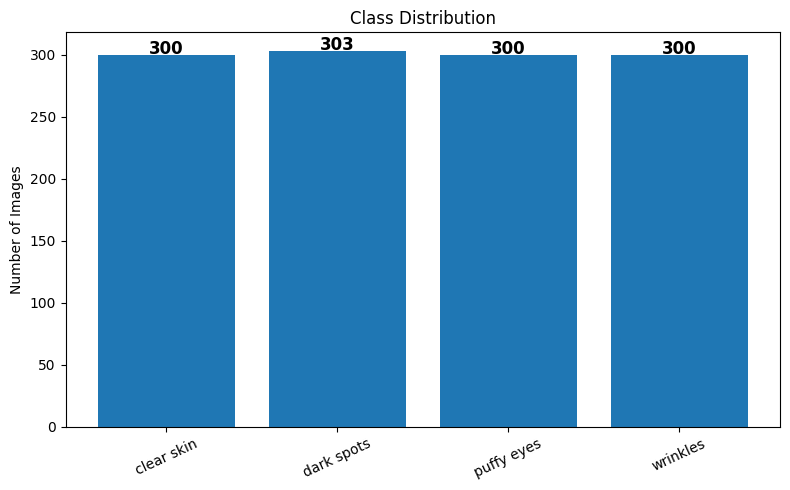

In [3]:
import matplotlib.pyplot as plt

root = "DATASET"
counts = {}

for cls in os.listdir(root):
    cls_path = os.path.join(root, cls)
    if os.path.isdir(cls_path):
        counts[cls] = len(os.listdir(cls_path))

classes = list(counts.keys())
vals = [counts[c] for c in classes]

plt.figure(figsize=(8,5))
bars = plt.bar(classes, vals)

# Add numbers above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 1,
             str(height),
             ha='center', fontsize=12, fontweight='bold')

plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

### - MODULE 2

In [5]:
import os, shutil, random, uuid
from pathlib import Path
import cv2
import numpy as np
import pandas as pd

ROOT = "DATASET"        # source
PROCESSED = "processed" # resized images
AUGMENTED = "augmented" # augmented images
OUTPUTS = "outputs"

for d in (PROCESSED, AUGMENTED, OUTPUTS):
    os.makedirs(d, exist_ok=True)

classes = sorted([d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT, d))])
print("Classes:", classes)

Classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']


#### Resize and normalize images (224x224).

In [6]:
TARGET_SIZE = (224, 224)  # (width, height)

def resize_image_save(src_path, dst_path, size=TARGET_SIZE):
    img = cv2.imread(src_path)
    if img is None:
        return False
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    cv2.imwrite(dst_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    return True

errors = []
for cls in classes:
    src_dir = os.path.join(ROOT, cls)
    dst_dir = os.path.join(PROCESSED, cls)
    os.makedirs(dst_dir, exist_ok=True)
    for fname in os.listdir(src_dir):
        src_p = os.path.join(src_dir, fname)
        dst_p = os.path.join(dst_dir, fname)
        if not resize_image_save(src_p, dst_p):
            errors.append(src_p)

print("Resize complete. unreadable files:", len(errors))
if errors:
    os.makedirs(os.path.join(OUTPUTS, "corrupt"), exist_ok=True)
    for p in errors:
        shutil.copy(p, os.path.join(OUTPUTS, "corrupt", os.path.basename(p)))

# Returns float32 array in [0,1], shape (224,224,3)
def load_and_normalize(path, size=TARGET_SIZE):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if (img.shape[1], img.shape[0]) != size:  # width, height
        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    img = img.astype("float32") / 255.0
    return img

Resize complete. unreadable files: 0


#### Apply image augmentation (flip, rotation, zoom).

In [7]:
import math
import random
import numpy as np
import cv2

def augment_simple_rgb(img, rotate_limit=20, scale_min=0.9, scale_max=1.1, p_flip=0.5):
    h, w = img.shape[:2]
    # flip
    if random.random() < p_flip:
        img = img[:, ::-1, :]

    # random rotation
    angle = random.uniform(-rotate_limit, rotate_limit)
    # random scale (zoom)
    scale = random.uniform(scale_min, scale_max)

    M = cv2.getRotationMatrix2D((w/2, h/2), angle, scale)
    aug = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    # final resize/crop to TARGET_SIZE
    aug = cv2.resize(aug, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    return aug

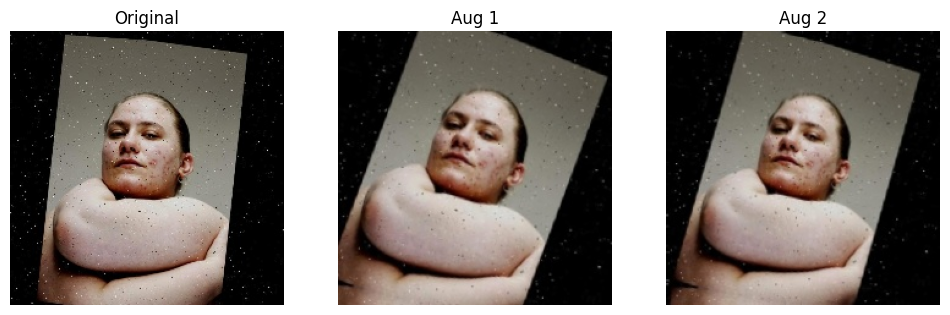

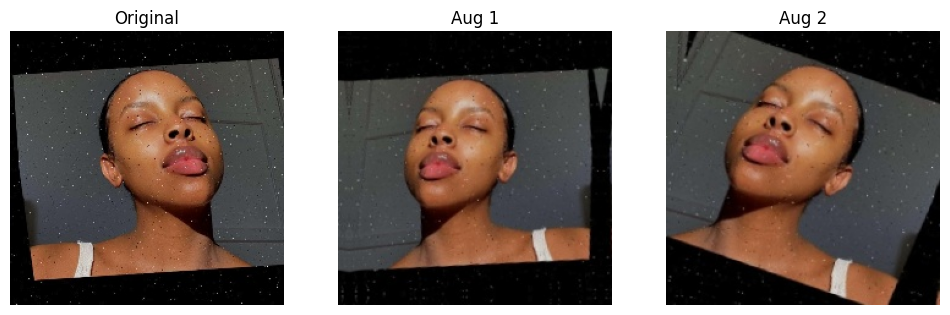

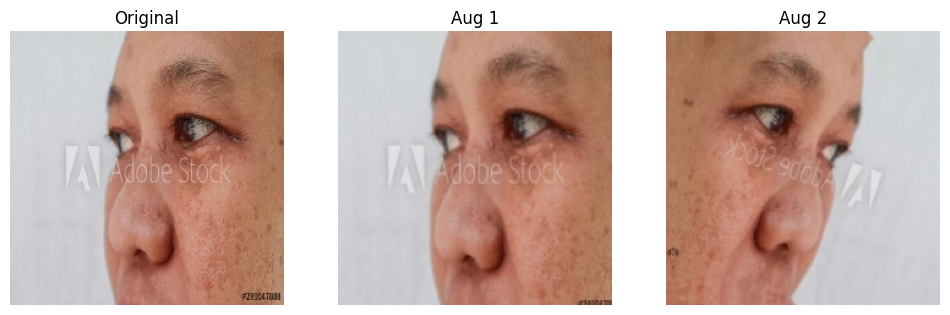

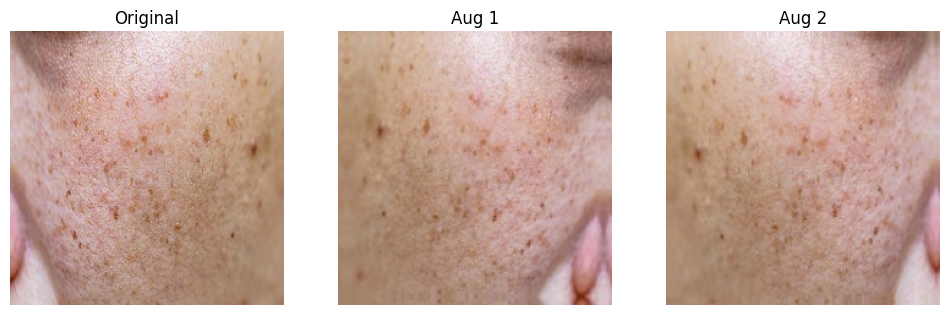

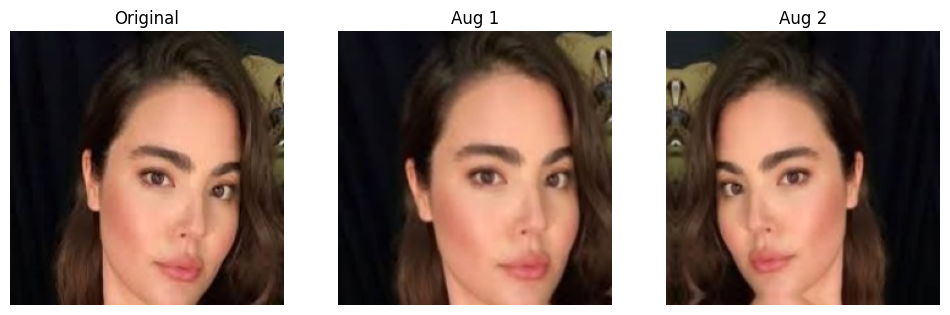

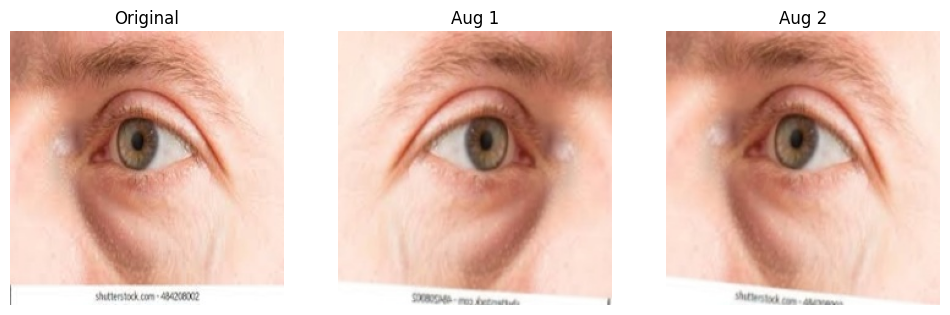

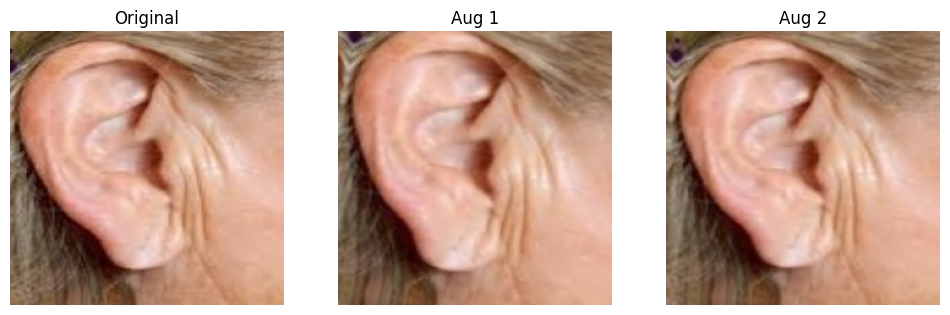

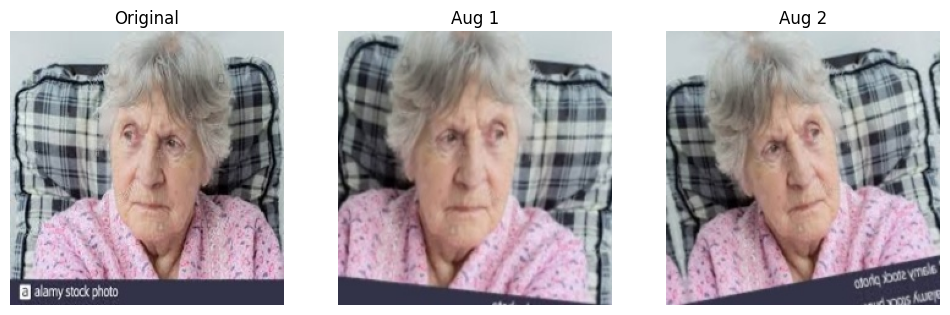

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_before_after(processed_folder, augmented_folder, samples=2):
    classes = os.listdir(processed_folder)

    for cls in classes:
        proc_dir = os.path.join(processed_folder, cls)
        aug_dir  = os.path.join(augmented_folder, cls)

        proc_files = random.sample(os.listdir(proc_dir), samples)

        for f in proc_files:
            base = os.path.splitext(f)[0]

            # original image
            orig = Image.open(os.path.join(proc_dir, f))

            # find aug images
            aug_files = [a for a in os.listdir(aug_dir) if a.startswith(base) and "aug" in a]

            total = 1 + len(aug_files)
            plt.figure(figsize=(4*total, 4))

            # Original
            plt.subplot(1, total, 1)
            plt.imshow(orig)
            plt.title("Original")
            plt.axis("off")

            # Augmented versions
            for i, a in enumerate(aug_files, 2):
                img = Image.open(os.path.join(aug_dir, a))
                plt.subplot(1, total, i)
                plt.imshow(img)
                plt.title(f"Aug {i-1}")
                plt.axis("off")

            plt.show()

show_before_after("processed", "augmented", samples=2)

#### Encode class labels using one-hot encoding.

In [14]:
mapping = {cls: idx for idx, cls in enumerate(classes)}
pd.DataFrame(list(mapping.items()), columns=["class", "index"]).to_csv(os.path.join(OUTPUTS, "class_mapping.csv"), index=False)
print("Mapping saved:", mapping)

def to_one_hot(index, num_classes=len(classes)):
    arr = np.zeros(num_classes, dtype=int)
    arr[index] = 1
    return arr

Mapping saved: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}


# MILESTONE 2

### -MODULE 3

#### Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os

#### Load MobileNetV2 & build the model

##### Define basic parameters

In [2]:
IMG_SIZE = 224
NUM_CLASSES = 4

##### Load MobileNetV2 + Build model

In [3]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(base_model.input, output)

##### Compile the model & Summary

In [4]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

#### Prepare callbacks & connect your data generators

##### Define output paths (safe)

In [6]:
OUTPUTS_DIR = "outputs"
os.makedirs(OUTPUTS_DIR, exist_ok=True)

MODEL_PATH = os.path.join(OUTPUTS_DIR, "efficientnetb0_best.keras")

#### Callbacks

In [10]:
os.makedirs("outputs", exist_ok=True)

checkpoint = ModelCheckpoint(
    "outputs/mobilenetv2_best.weights.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

callbacks = [checkpoint]

##### Define generators(important for training quality)

In [7]:
DATASET_PATH = "DATASET/"

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

val_gen = train_gen

Found 1207 images belonging to 4 classes.


In [8]:
print(train_gen)
print(val_gen)
print(train_gen.class_indices)

{'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}


#### Train MobileNetV2 (Initial Training)

##### Calculate training steps

In [9]:
BATCH_SIZE = 32

steps_per_epoch = train_gen.samples // BATCH_SIZE
validation_steps = val_gen.samples // BATCH_SIZE

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 37
Validation steps: 37


##### Start model training

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 1.2076 - accuracy: 0.4863
Epoch 1: val_accuracy improved from -inf to 0.71168, saving model to outputs\mobilenetv2_best.weights.h5
38/38 [==============================] - 82s 2s/step - loss: 1.2076 - accuracy: 0.4863 - val_loss: 0.7640 - val_accuracy: 0.7117
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.7525 - accuracy: 0.7026
Epoch 2: val_accuracy improved from 0.71168 to 0.80779, saving model to outputs\mobilenetv2_best.weights.h5
38/38 [==============================] - 69s 2s/step - loss: 0.7525 - accuracy: 0.7026 - val_loss: 0.5659 - val_accuracy: 0.8078
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.7697
Epoch 3: val_accuracy improved from 0.80779 to 0.83430, saving model to outputs\mobilenetv2_best.weights.h5
38/38 [==============================] - 69s 2s/step - loss: 0.6206 - accuracy: 0.7697 - val_loss: 0.4871 - val_accuracy: 0.8343
Epoch 4/50

In [12]:
print("Training Accuracy:", history.history["accuracy"][-1])
print("Validation Accuracy:", history.history["val_accuracy"][-1])

Training Accuracy: 0.9933720231056213
Validation Accuracy: 0.9991714954376221


##### Plot accuracy & loss

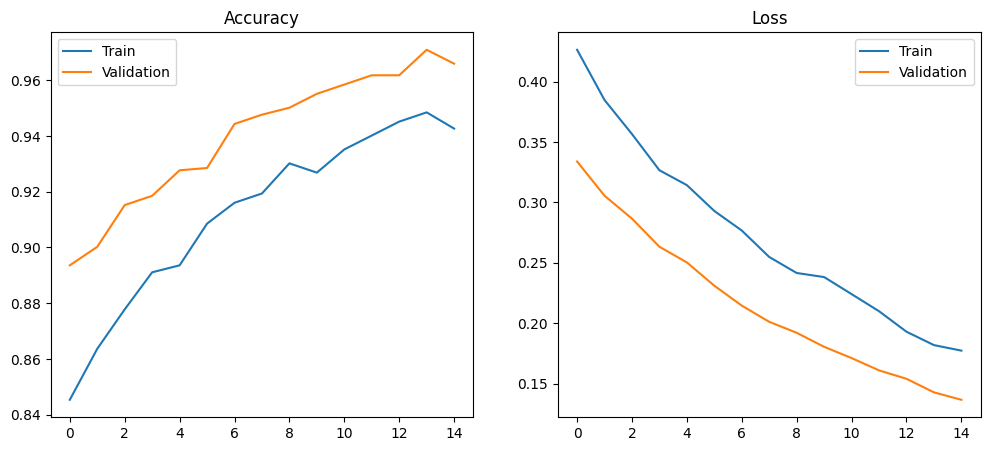

In [43]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.title("Loss")

plt.show()

### -MODULE 4

#### Install & Import Requirements

In [105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#### Load Haar Cascade (Face Detector)

In [106]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

assert not face_cascade.empty(), "Haar Cascade failed to load"
print("Haar Cascade loaded")

Haar Cascade loaded


#### Load a Test Image, Face Detection & DRAW BOUNDING BOX

Faces detected: 1


(-0.5, 639.5, 639.5, -0.5)

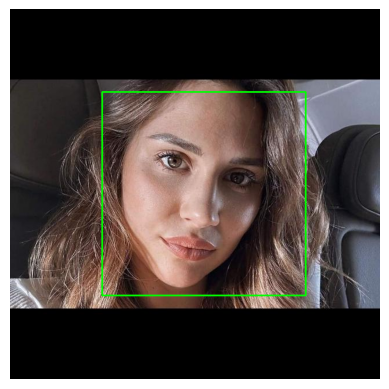

In [107]:
TEST_IMAGE_PATH = r"DATASET\clear skin\clear_skin_008.jpg"

assert os.path.exists(TEST_IMAGE_PATH), "Image path incorrect"

img = cv2.imread(TEST_IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")

#Face Detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor=1.2,
    minNeighbors=6,
    minSize=(80, 80)
)

print("Faces detected:", len(faces))
assert len(faces) > 0, "No face detected"

#DRAW BOUNDING BOX
img_box = img_rgb.copy()

for (x, y, w, h) in faces:
    cv2.rectangle(img_box, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(img_box)
plt.axis("off")

#### FACE CROP

(-0.5, 351.5, 351.5, -0.5)

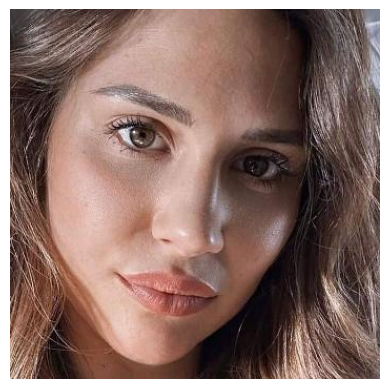

In [108]:
(x, y, w, h) = faces[0]
face_crop = img_rgb[y:y+h, x:x+w]

plt.imshow(face_crop)
plt.axis("off")

#### SKIN EXTRACTION (FOR KEY TO CORRECT PREDICTION)

(-0.5, 351.5, 351.5, -0.5)

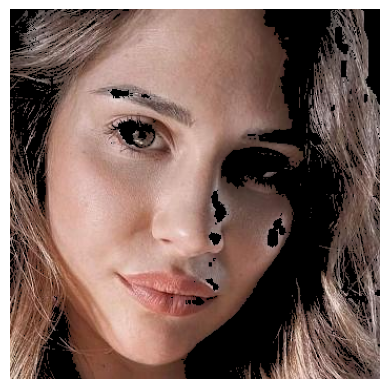

In [109]:
hsv = cv2.cvtColor(face_crop, cv2.COLOR_RGB2HSV)

lower_skin = np.array([0, 20, 70], dtype=np.uint8)
upper_skin = np.array([20, 255, 255], dtype=np.uint8)

skin_mask = cv2.inRange(hsv, lower_skin, upper_skin)
skin_only = cv2.bitwise_and(face_crop, face_crop, mask=skin_mask)

plt.imshow(skin_only)
plt.axis("off")

#### PREPROCESS FOR CNN MODEL

In [110]:
skin_resized = cv2.resize(skin_only, (224, 224))
skin_normalized = skin_resized / 255.0
skin_input = np.expand_dims(skin_normalized, axis=0)

print("Model input shape:", skin_input.shape)

Model input shape: (1, 224, 224, 3)


#### LOAD MODEL & CLASS LABELS

In [111]:
class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)

model.load_weights("outputs/mobilenetv2_best.weights.h5")
print("Model loaded")

Classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']
Model loaded


#### PREDICTION

In [112]:
preds = model.predict(skin_input)[0]

predicted_class = class_names[np.argmax(preds)]
confidence = np.max(preds) * 100

# Safety logic
if confidence < 60:
    predicted_class = "clear_skin"

print("Prediction:", predicted_class)
print("Confidence:", confidence)

1/1 [==============================] - 0s 59ms/step
Prediction: clear_skin
Confidence: 59.2382550239563


#### FINAL OUTPUT IMAGE

(-0.5, 639.5, 639.5, -0.5)

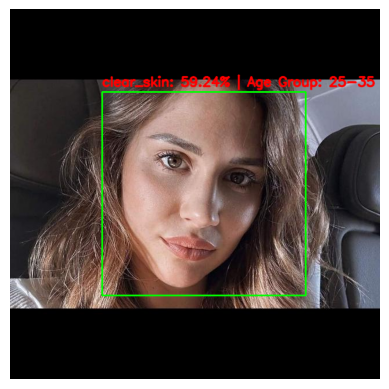

In [120]:
label = f"{predicted_class}: {confidence:.2f}% | Age Group: {age_group}"

final_img = img_rgb.copy()
cv2.rectangle(final_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2.putText(
    final_img,
    label,
    (x, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.75,
    (255, 0, 0),
    2,
    cv2.LINE_AA
)

plt.imshow(final_img)
plt.axis("off")